<h1 align = 'center'>Fraud Detection in Health Care Charges</h1>

## LAKSHMI PRIYA RAMISETTY - lramiset@mail.yu.edu

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.pca import PCA
from pyod.models.knn import KNN

sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("inpatientCharges.csv")
df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


<h2 align='center'>1. Data Cleaning</h2>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   DRG Definition                        163065 non-null  object
 1   Provider Id                           163065 non-null  int64 
 2   Provider Name                         163065 non-null  object
 3   Provider Street Address               163065 non-null  object
 4   Provider City                         163065 non-null  object
 5   Provider State                        163065 non-null  object
 6   Provider Zip Code                     163065 non-null  int64 
 7   Hospital Referral Region Description  163065 non-null  object
 8    Total Discharges                     163065 non-null  int64 
 9    Average Covered Charges              163065 non-null  object
 10   Average Total Payments               163065 non-null  object
 11  Average Medic

In [4]:
df.describe()

,Provider Id,Provider Zip Code,Total Discharges
count,163065.000000,163065.000000,163065.000000
mean,255569.865428,47938.121908,42.776304
std,151563.671767,27854.323080,51.104042
min,10001.000000,1040.000000,11.000000
25%,110092.000000,27261.000000,17.000000
50%,250007.000000,44309.000000,27.000000
75%,380075.000000,72901.000000,49.000000
max,670077.000000,99835.000000,3383.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values: \n", missing_values)

Missing Values: 
 DRG Definition                          0
Provider Id                             0
Provider Name                           0
Provider Street Address                 0
Provider City                           0
Provider State                          0
Provider Zip Code                       0
Hospital Referral Region Description    0
 Total Discharges                       0
 Average Covered Charges                0
 Average Total Payments                 0
Average Medicare Payments               0
dtype: int64


In [6]:
df.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       ' Total Discharges ', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments'],
      dtype='object')

There are spaces in the column names, lets remove them.

In [7]:
# Rename columns
df = df.rename(columns={
    'DRG Definition': 'DrgDefinition',
    'Provider Id': 'ProviderId',
    'Provider Name': 'ProviderName',
    'Provider Street Address': 'ProviderStreetAddress',
    'Provider City': 'ProviderCity',
    'Provider State': 'ProviderState',
    'Provider Zip Code': 'ProviderZipCode',
    'Hospital Referral Region Description': 'HospitalReferralRegion',
    ' Total Discharges ': 'TotalDischarges',
    ' Average Covered Charges ': 'AvgCoveredCharges',
    ' Average Total Payments ': 'AvgTotalPayments',
    'Average Medicare Payments': 'AvgMedicarePayments'
})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   DrgDefinition           163065 non-null  object
 1   ProviderId              163065 non-null  int64 
 2   ProviderName            163065 non-null  object
 3   ProviderStreetAddress   163065 non-null  object
 4   ProviderCity            163065 non-null  object
 5   ProviderState           163065 non-null  object
 6   ProviderZipCode         163065 non-null  int64 
 7   HospitalReferralRegion  163065 non-null  object
 8   TotalDischarges         163065 non-null  int64 
 9   AvgCoveredCharges       163065 non-null  object
 10  AvgTotalPayments        163065 non-null  object
 11  AvgMedicarePayments     163065 non-null  object
dtypes: int64(3), object(9)
memory usage: 14.9+ MB


Average Covered Charges, Average Total Payments, Average Medicare Payments are objects, lets remove the dollar sign and convert them to float

In [9]:
df['AvgCoveredCharges'] = df['AvgCoveredCharges'].replace('[\$,]', '', regex=True).astype(float)
df['AvgTotalPayments'] = df['AvgTotalPayments'].replace('[\$,]', '', regex=True).astype(float)
df['AvgMedicarePayments'] = df['AvgMedicarePayments'].replace('[\$,]', '', regex=True).astype(float)
df.head()

,DrgDefinition,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44


In [10]:
# Convert 'Provider Zip Code' and ProviderIdto string
df['ProviderZipCode'] = df['ProviderZipCode'].astype(str)
df['ProviderId'] = df['ProviderId'].astype(str)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DrgDefinition           163065 non-null  object 
 1   ProviderId              163065 non-null  object 
 2   ProviderName            163065 non-null  object 
 3   ProviderStreetAddress   163065 non-null  object 
 4   ProviderCity            163065 non-null  object 
 5   ProviderState           163065 non-null  object 
 6   ProviderZipCode         163065 non-null  object 
 7   HospitalReferralRegion  163065 non-null  object 
 8   TotalDischarges         163065 non-null  int64  
 9   AvgCoveredCharges       163065 non-null  float64
 10  AvgTotalPayments        163065 non-null  float64
 11  AvgMedicarePayments     163065 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 14.9+ MB


In [12]:
# Check for duplicates
duplicates = df.duplicated()
print("Duplicates:\n", duplicates.sum())

Duplicates:
 0


In [13]:
df.count()

DrgDefinition             163065
ProviderId                163065
ProviderName              163065
ProviderStreetAddress     163065
ProviderCity              163065
ProviderState             163065
ProviderZipCode           163065
HospitalReferralRegion    163065
TotalDischarges           163065
AvgCoveredCharges         163065
AvgTotalPayments          163065
AvgMedicarePayments       163065
dtype: int64

In [14]:
df.head()

,DrgDefinition,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44


In [15]:
for col in df.select_dtypes(include="object").columns:
    print(df[col].value_counts())

DrgDefinition
194 - SIMPLE PNEUMONIA & PLEURISY W CC                                      3023
690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                             2989
292 - HEART FAILURE & SHOCK W CC                                            2953
392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC                2950
641 - MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/ELECTROLYTES W/O MCC    2899
                                                                            ... 
315 - OTHER CIRCULATORY SYSTEM DIAGNOSES W CC                                859
473 - CERVICAL SPINAL FUSION W/O CC/MCC                                      846
917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC                               843
251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC                 727
885 - PSYCHOSES                                                              613
Name: count, Length: 100, dtype: int64
ProviderId
160083    100
360035    100
330106    100
100

In [16]:
# Print the number of unique values in each column
for column in df.select_dtypes(include="object").columns:
    unique_values = df[column].nunique()
    print(f"{column}: {unique_values} unique values")

DrgDefinition: 100 unique values
ProviderId: 3337 unique values
ProviderName: 3201 unique values
ProviderStreetAddress: 3326 unique values
ProviderCity: 1977 unique values
ProviderState: 51 unique values
ProviderZipCode: 3053 unique values
HospitalReferralRegion: 306 unique values


There are 3201 unique providers.

<h2 align='center'>2. EDA</h2>

### The distribution of single variable

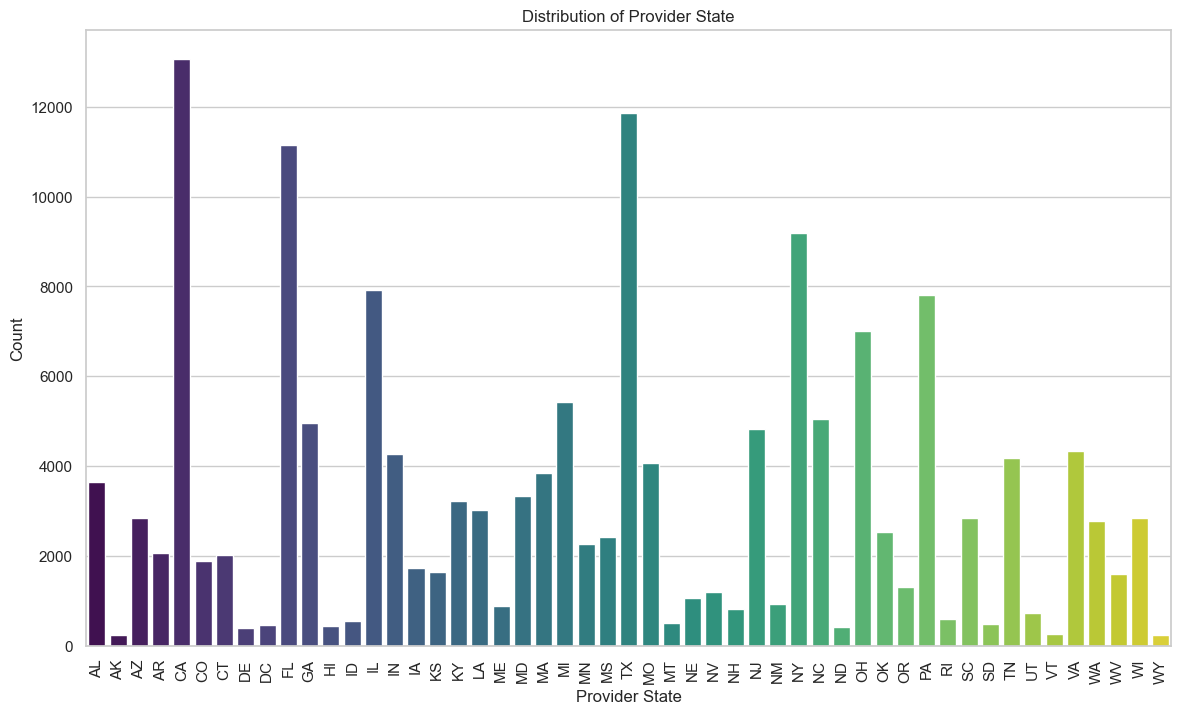

In [17]:
# Distribution of 'Provider State'
plt.figure(figsize=(14, 8))
sns.countplot(x='ProviderState', data=df, palette='viridis')
plt.title('Distribution of Provider State')
plt.xlabel('Provider State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

CA and TX have a lot of records.

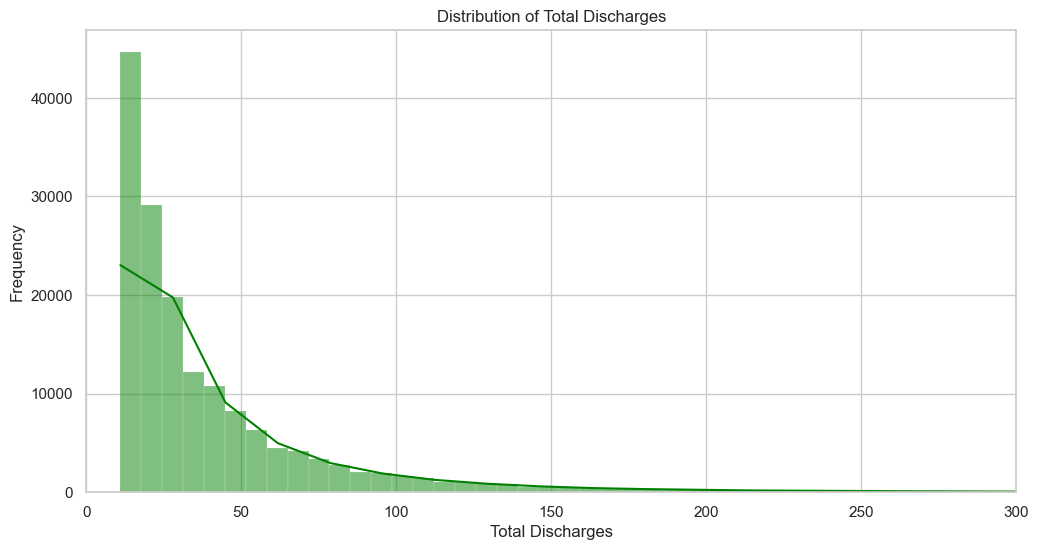

In [18]:
# Distribution of a single variable (e.g., 'Total Discharges')
plt.figure(figsize=(12, 6))
sns.histplot(df['TotalDischarges'], bins=500, kde=True, color='green')
plt.title('Distribution of Total Discharges')
plt.xlabel('Total Discharges')
plt.ylabel('Frequency')
plt.xlim(0, 300)  # Set X-axis limit
plt.show()

Most of the providers have total discharges less than 100

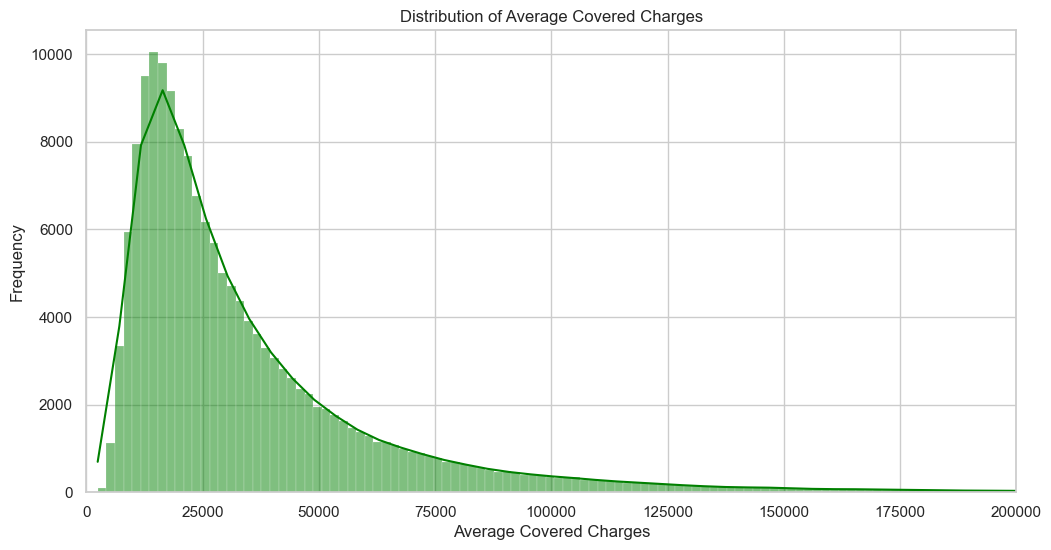

In [19]:
# Distribution of a single variable using histplot (e.g., 'Average Covered Charges')
plt.figure(figsize=(12, 6))
sns.histplot(df['AvgCoveredCharges'], bins=500, kde=True, color='green')
plt.title('Distribution of Average Covered Charges')
plt.xlabel('Average Covered Charges')
plt.ylabel('Frequency')
plt.xlim(0, 200000)  # Set X-axis limit
plt.show()

Most of the Average Covered Charges are under 100000

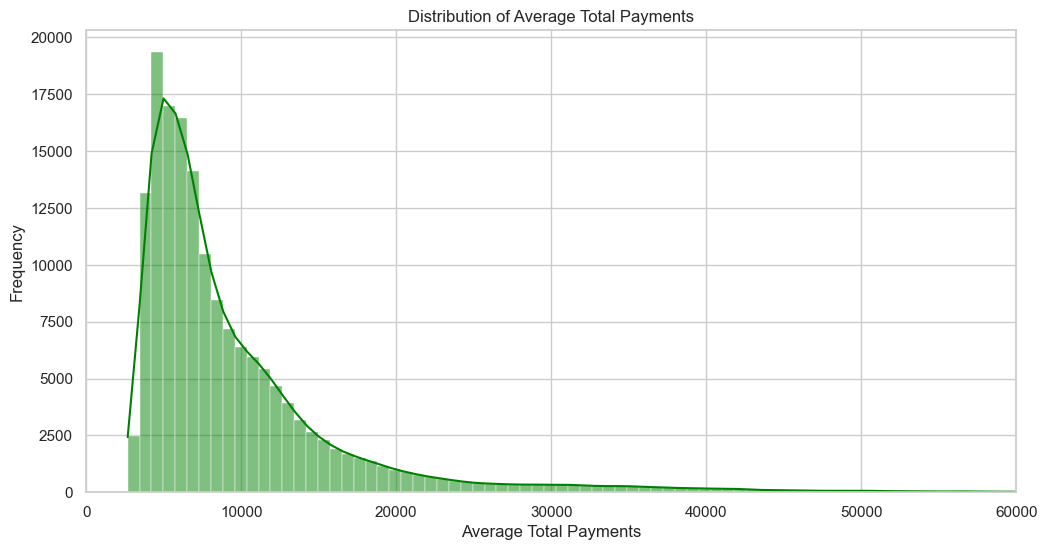

In [20]:
# Distribution of a single variable using histplot with limited X-axis (e.g., 'Average Total Payments')
plt.figure(figsize=(12, 6))
sns.histplot(df['AvgTotalPayments'], bins=200, kde=True, color='green')
plt.title('Distribution of Average Total Payments')
plt.xlabel('Average Total Payments')
plt.ylabel('Frequency')
plt.xlim(0, 60000)  # Set X-axis limit
plt.show()

Most of the Average Total Payments are under 30000

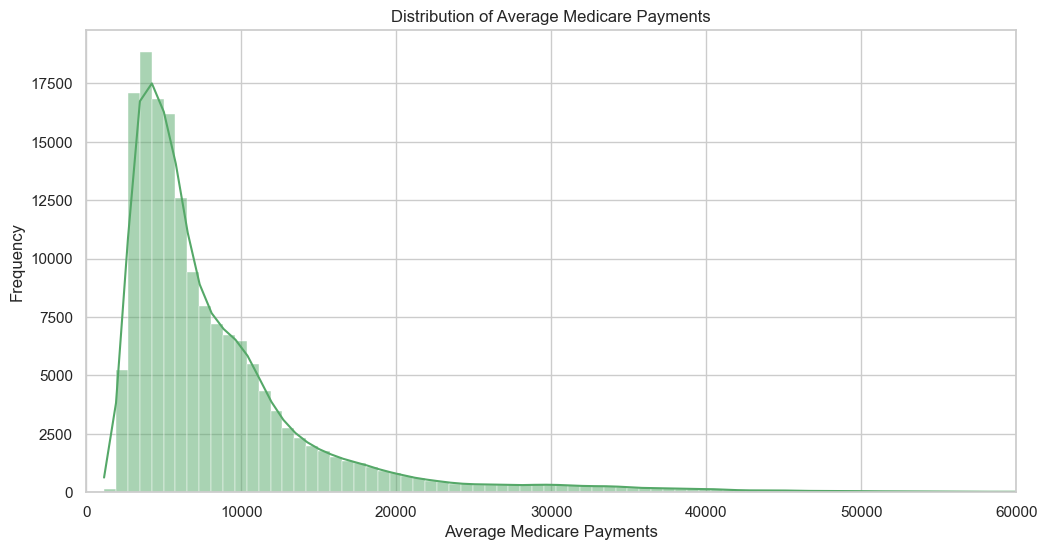

In [21]:
# Distribution of a single variable using histplot with limited X-axis (e.g., 'Average Medicare Payments')
plt.figure(figsize=(12, 6))
sns.histplot(df['AvgMedicarePayments'], bins=200, kde=True, color='g')
plt.title('Distribution of Average Medicare Payments')
plt.xlabel('Average Medicare Payments')
plt.ylabel('Frequency')
plt.xlim(0, 60000)  # Set X-axis limit
plt.show()

Most of the Average Medicare Payments are under 30000

<Axes: xlabel='AvgMedicarePayments'>

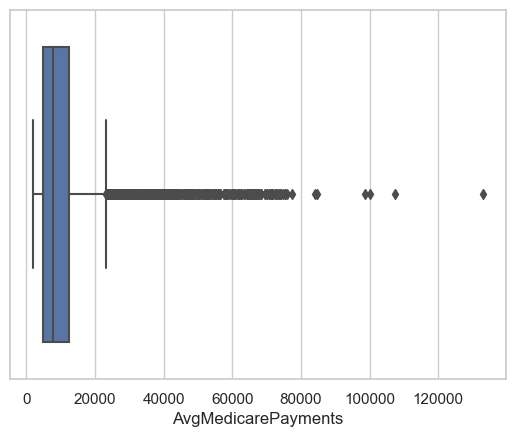

In [22]:
# Checking AvgMedicarePayments for NY
sns.boxplot(x=df[df["ProviderState"] == "NY"]["AvgMedicarePayments"])

There are a lot of outliers in AvgMedicarePayments, maybe because of the cost of living in NY.

<Axes: xlabel='AvgMedicarePayments'>

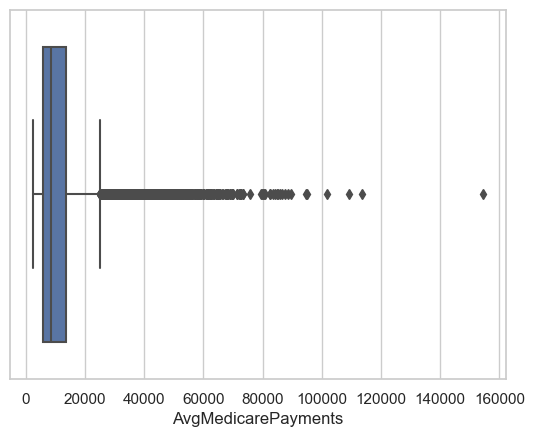

In [23]:
# Checking AvgMedicarePayments for CA
sns.boxplot(x=df[df["ProviderState"] == "CA"]["AvgMedicarePayments"])

There are a lot of outliers in AvgMedicarePayments, maybe because of the cost of living in CA.

<Axes: xlabel='AvgMedicarePayments'>

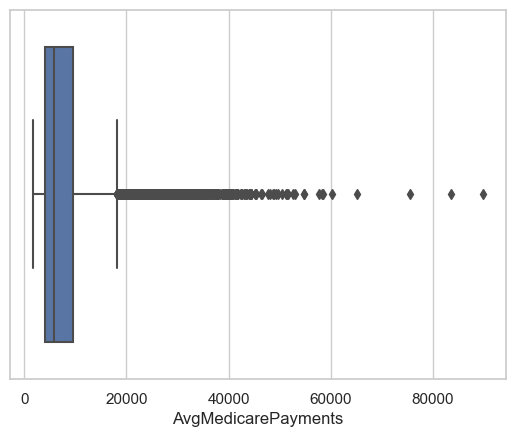

In [24]:
# Checking AvgMedicarePayments for TX
sns.boxplot(x=df[df["ProviderState"] == "TX"]["AvgMedicarePayments"])

There are a lot of outliers in AvgMedicarePayments, maybe because of the cost of living and higher population in TX.

<Axes: xlabel='AvgMedicarePayments'>

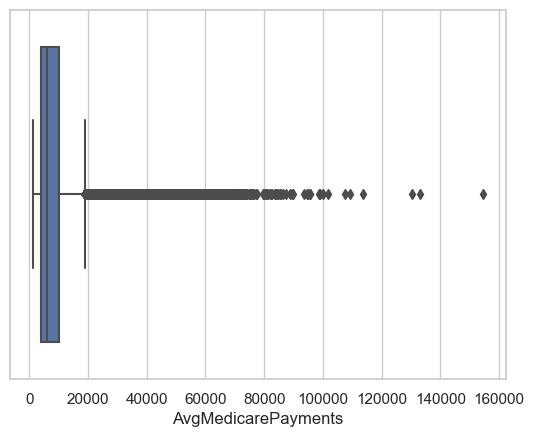

In [25]:
sns.boxplot(x=df['AvgMedicarePayments'])

<Axes: xlabel='AvgTotalPayments'>

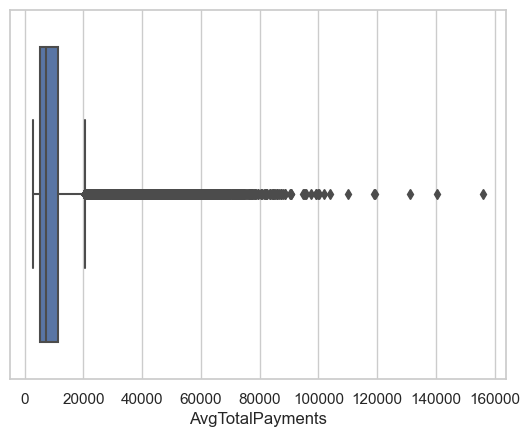

In [26]:
sns.boxplot(x=df['AvgTotalPayments'])

<Axes: xlabel='AvgCoveredCharges'>

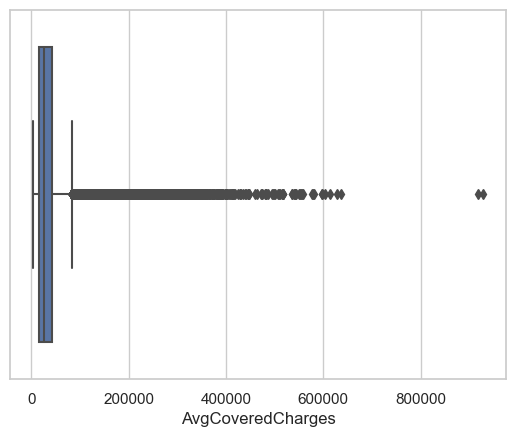

In [27]:
sns.boxplot(x=df['AvgCoveredCharges'])

<Axes: xlabel='TotalDischarges'>

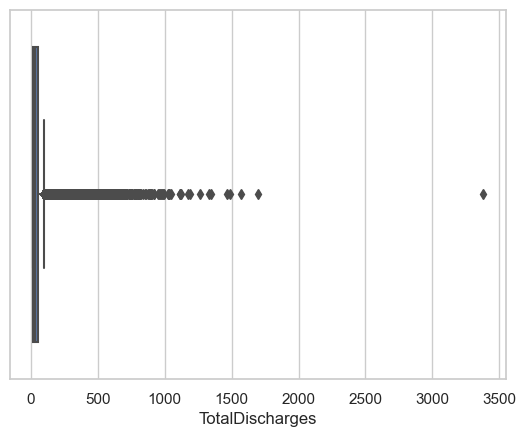

In [28]:
sns.boxplot(x=df['TotalDischarges'])

### The distribution of one variable by another categorical variable

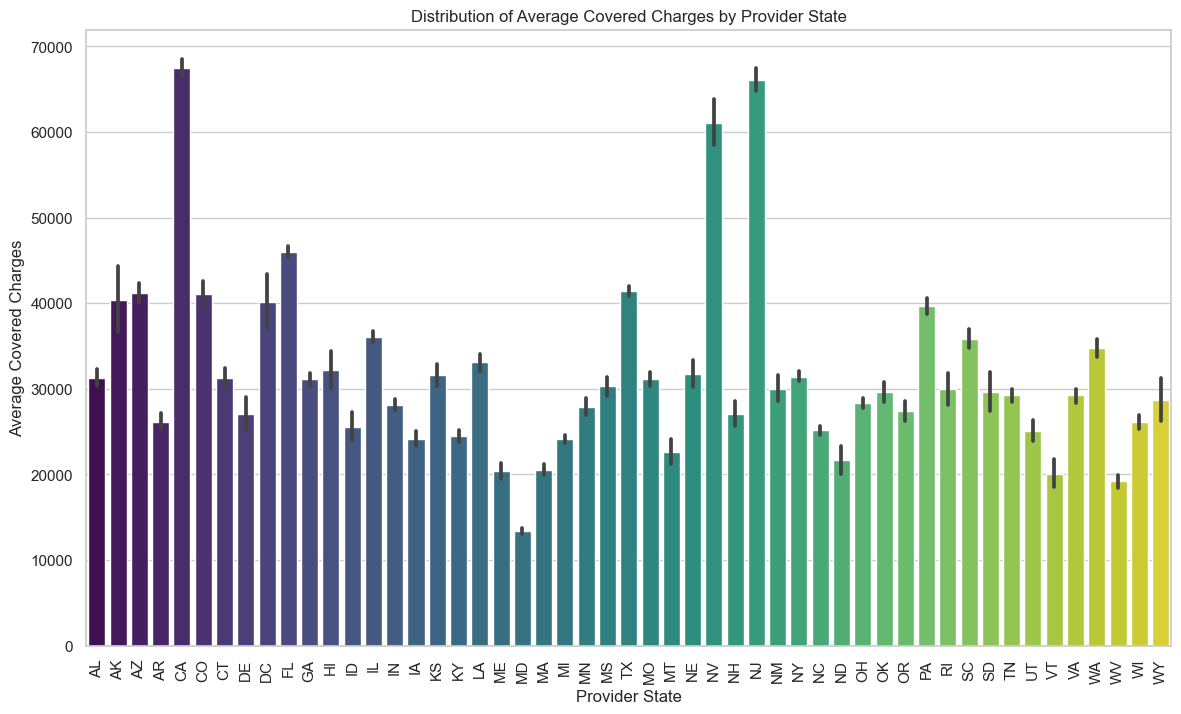

In [29]:
# Distribution of 'Average Covered Charges' by 'Provider State' using a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='ProviderState', y='AvgCoveredCharges', data=df, palette='viridis')
plt.title('Distribution of Average Covered Charges by Provider State')
plt.xlabel('Provider State')
plt.ylabel('Average Covered Charges')
plt.xticks(rotation = 90)
plt.show()

 CA, NJ and NV have high Average Covered Charges

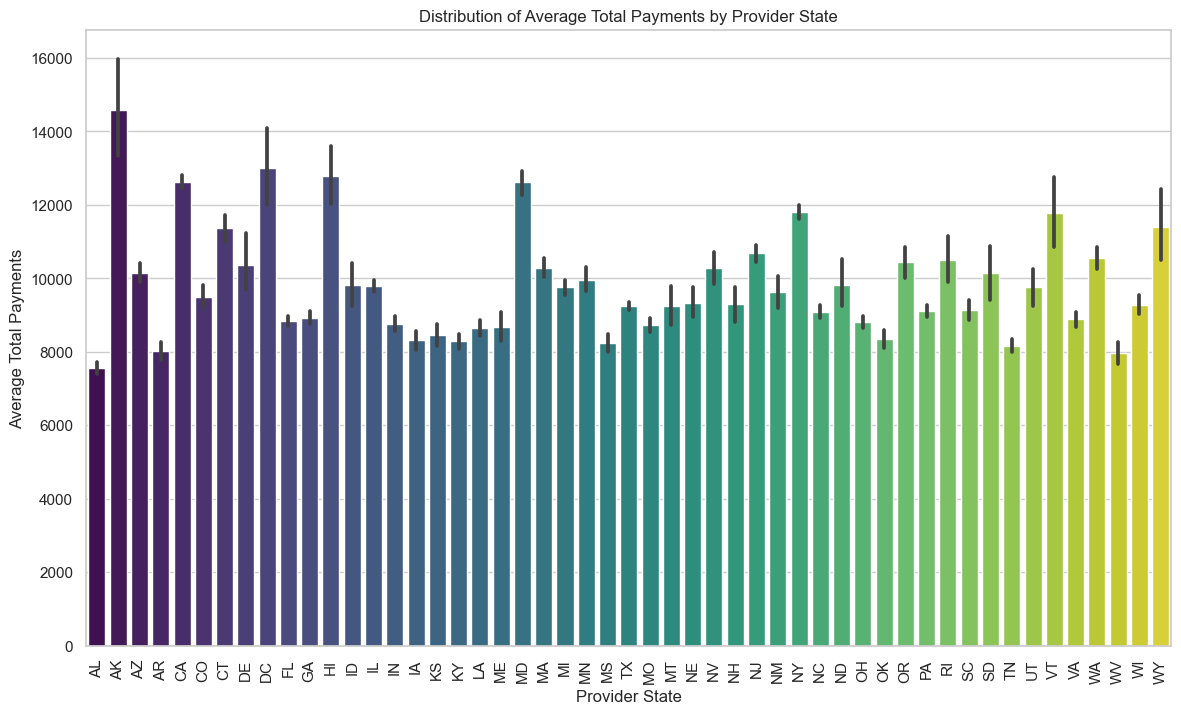

In [30]:
# Distribution of 'Average Total Payments' by 'Provider State' using a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='ProviderState', y='AvgTotalPayments', data=df, palette='viridis')
plt.title('Distribution of Average Total Payments by Provider State')
plt.xlabel('Provider State')
plt.ylabel('Average Total Payments')
plt.xticks(rotation = 90)
plt.show()

AK has high Average Total Payments

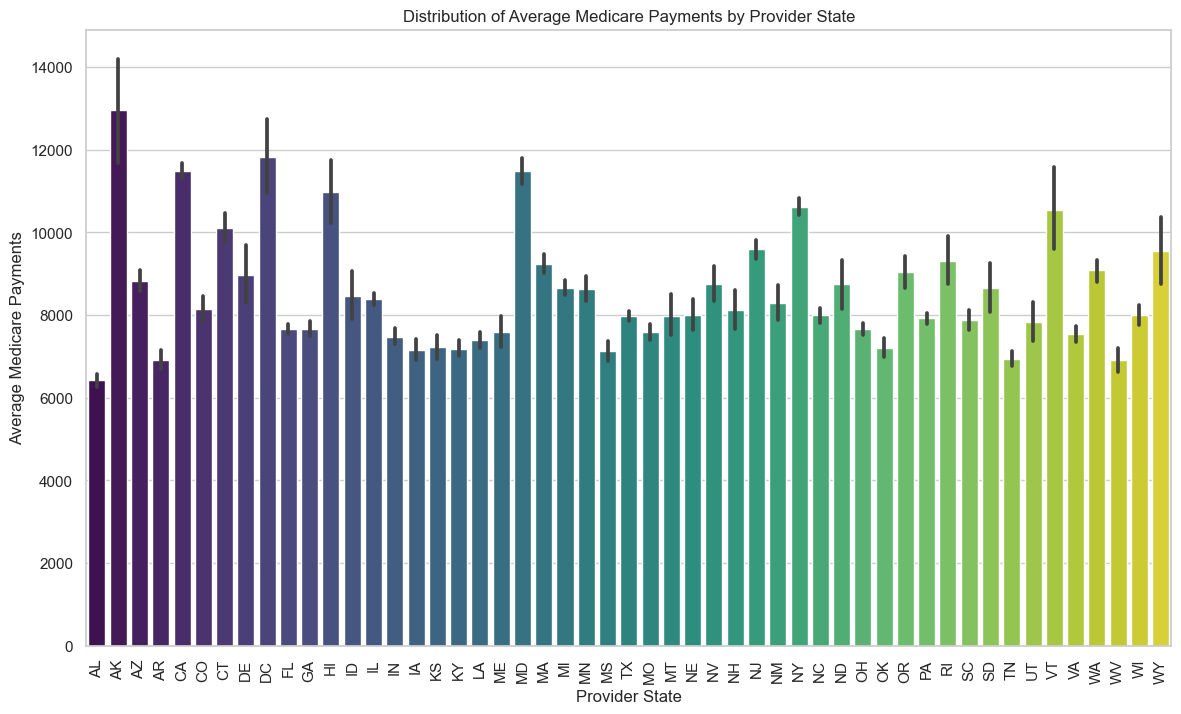

In [31]:
# Distribution of 'Average Medicare Payments' by 'Provider State' using a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='ProviderState', y='AvgMedicarePayments', data=df, palette='viridis')
plt.title('Distribution of Average Medicare Payments by Provider State')
plt.xlabel('Provider State')
plt.ylabel('Average Medicare Payments')
plt.xticks(rotation = 90)
plt.show()

AK has really high Average Medicare Payments

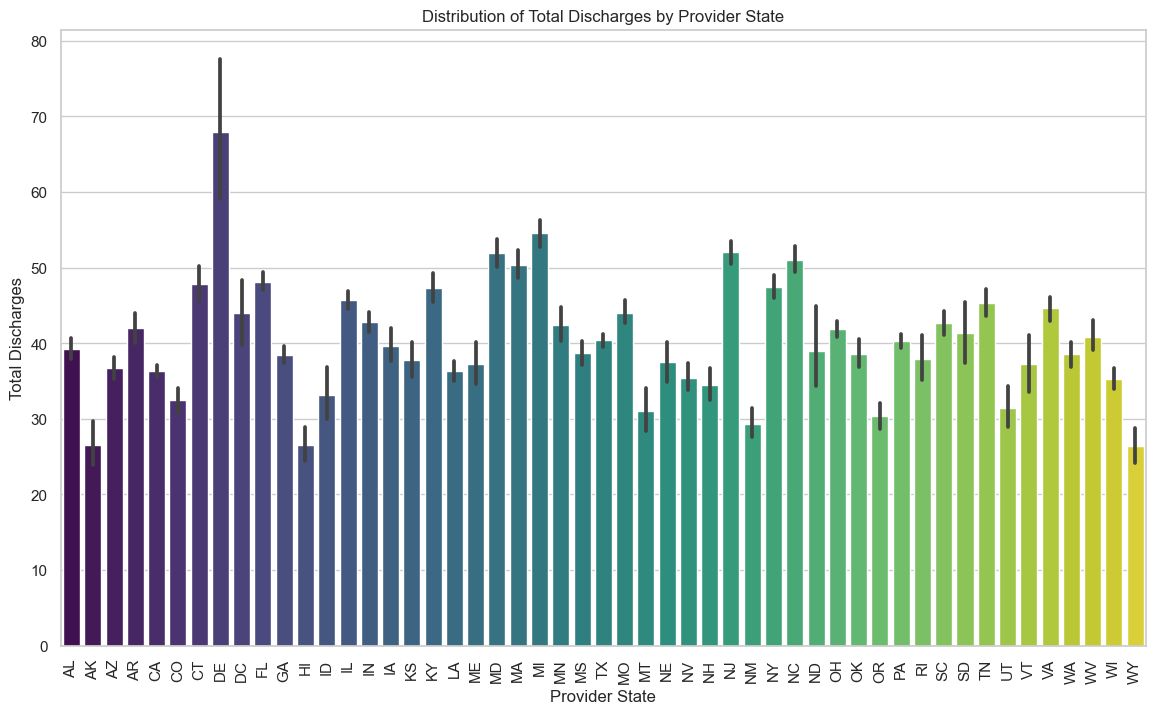

In [32]:
# Distribution of 'Total Discharges' by 'Provider State' using a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='ProviderState', y='TotalDischarges', data=df, palette='viridis')
plt.title('Distribution of Total Discharges by Provider State')
plt.xlabel('Provider State')
plt.ylabel('Total Discharges')
plt.xticks(rotation = 90)
plt.show()

DE has exceptionally high Total Discharges

### The interactions of two or three variables.

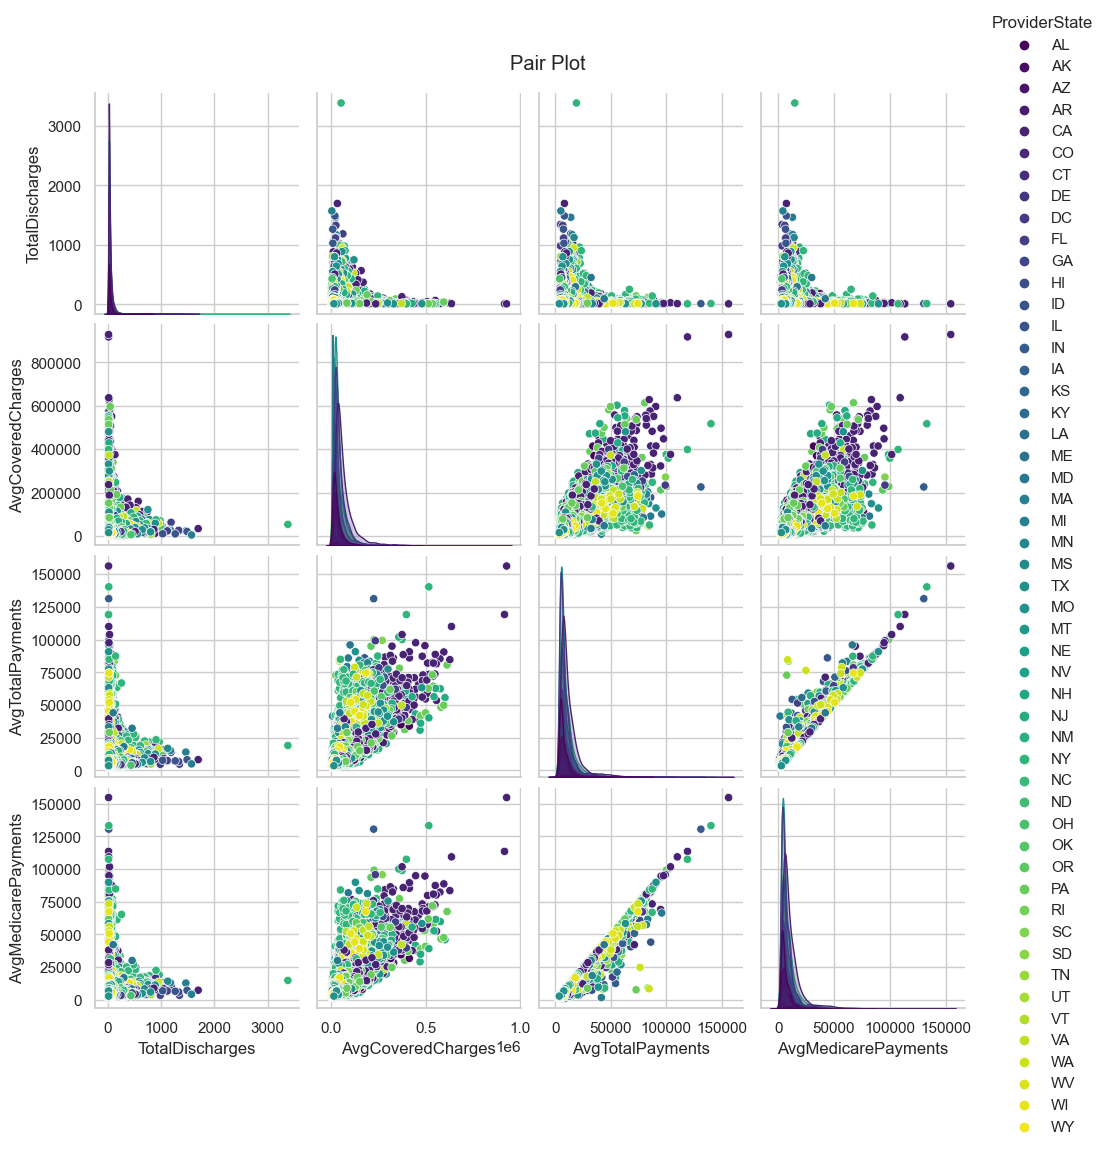

In [33]:
# Create a pair plot
sns.pairplot(df, hue="ProviderState", palette='viridis')
plt.suptitle('Pair Plot', y=1.02)
plt.show()

<h2 align='center'> 3. Create 20 features</h2>

In [34]:
df.head()

,DrgDefinition,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44


In [35]:
# Feature 1 - Creating a interstate region feature to group states
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West', 'CO': 'West',
    'CT': 'Northeast', 'DC': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South', 'HI': 'West', 'ID': 'West',
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'KY': 'South', 'LA': 'South',
    'ME': 'Northeast', 'MD': 'South', 'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South',
    'MO': 'Midwest', 'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest', 'OK': 'South',
    'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South', 'SD': 'Midwest', 'TN': 'South',
    'TX': 'South', 'UT': 'West', 'VT': 'Northeast', 'VA': 'South', 'WA': 'West', 'WV': 'South',
    'WI': 'Midwest', 'WY': 'West'
}

# Create a new 'Region' feature
df['InterstateRegion'] = df['ProviderState'].map(state_to_region)
df.head()

,DrgDefinition,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,South
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,South
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,South
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,South
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,South


`Why?` This helps identify clusters in interstate regions like West, NorthEast, South, MidWest to generalize regions and find frauds in each region instead of each state. This feature will help me analyze frauds in each region. It serves as an additional dimension that can enhance the overall analysis of provider behavior and potentially uncover patterns indicative of fraud or irregularities.

In [36]:
# Feature 2: Extract Drg Code from DrgCategory and drop DrgCategory
df['DrgCode'] = df['DrgDefinition'].apply(lambda x: x.split(' - ')[0] if ' - ' in x else x)
df.drop(columns=["DrgDefinition"], inplace=True)
df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion,DrgCode
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,South,039
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,South,039
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,South,039
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,South,039
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,South,039


`Why?` Extracting DrgCode is used to encode the categorical variable and will help with identifying clusters to help identify fraud. 

In [37]:
df.DrgCode.nunique()

100

In [38]:
df[df["ProviderState"] != df['HospitalReferralRegion'].apply(lambda x: x.split(' - ')[0] if ' - ' in x else x)]

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion,DrgCode
45,30101,WESTERN ARIZONA REGIONAL MEDICAL CTR,2735 SILVER CREEK ROAD,BULLHEAD CITY,AZ,86442,NV - Las Vegas,26,60608.69,6941.03,5652.65,West,039
54,40027,BAXTER REGIONAL MEDICAL CENTER,624 HOSPITAL DRIVE,MOUNTAIN HOME,AR,72653,MO - Springfield,76,16582.34,5496.31,4424.64,South,039
132,60013,MERCY REGIONAL MEDICAL CENTER,1010 THREE SPRINGS BLVD,DURANGO,CO,81301,NM - Albuquerque,11,26928.54,7578.63,6658.27,West,039
158,80007,BEEBE MEDICAL CENTER,424 SAVANNAH RD,LEWES,DE,19958,MD - Salisbury,41,39209.60,7217.19,5536.21,South,039
243,110003,SATILLA REGIONAL MEDICAL CENTER,410 DARLING AVENUE,WAYCROSS,GA,31501,FL - Jacksonville,11,12835.72,5754.72,4840.18,South,039
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163015,510071,BLUEFIELD REGIONAL MEDICAL CENTER,500 CHERRY ST,BLUEFIELD,WV,24701,VA - Roanoke,20,7794.75,4032.30,3411.30,South,948
163019,520013,SACRED HEART HSPTL,900 W CLAIREMONT AVE,EAU CLAIRE,WI,54701,MN - Minneapolis,17,11501.70,4880.11,3268.88,Midwest,948
163034,520070,MAYO CLINIC HEALTH SYSTEM EAU CLAIRE HOSPITAL,1221 WHIPPLE ST,EAU CLAIRE,WI,54703,MN - Minneapolis,26,11205.23,4349.11,2825.57,Midwest,948
163056,530002,CAMPBELL COUNTY MEMORIAL HOSPITAL,501 SOUTH BURMA AVENUE,GILLETTE,WY,82716,MT - Billings,12,13756.50,6889.33,5673.50,West,948


We can see that Hospital Referral Region is different for some providers with their state. According to researchers at Dartmouth College, HRRs are constructed based on patterns of patient referral for major cardiovascular procedures. These regions are intended to represent the natural markets for tertiary medical care, reflecting where patients are likely to seek hospital services. The goal is to study variations in healthcare utilization and spending across different regions.

In [39]:
# Feature 3: Extract Hospital Referral State
df['HospitalReferralState'] = df['HospitalReferralRegion'].apply(lambda x: x.split(' - ')[0] if ' - ' in x else x)
df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,HospitalReferralRegion,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion,DrgCode,HospitalReferralState
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,South,039,AL
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,South,039,AL
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,South,039,AL
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,South,039,AL
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,South,039,AL


`Why?` Through this analysis, we can identify variations in healthcare costs between the two neighbouring regions.

In [40]:
# Feature 4: Extract Hospital Referral City and drop HospitalReferralRegion
df['HospitalReferralCity'] = df['HospitalReferralRegion'].apply(lambda x: x.split(' - ')[1] if ' - ' in x else x)
df.drop(columns=["HospitalReferralRegion"], inplace=True)
df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion,DrgCode,HospitalReferralState,HospitalReferralCity
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,91,32963.07,5777.24,4763.73,South,039,AL,Dothan
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,14,15131.85,5787.57,4976.71,South,039,AL,Birmingham
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,24,37560.37,5434.95,4453.79,South,039,AL,Birmingham
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,25,13998.28,5417.56,4129.16,South,039,AL,Birmingham
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,18,31633.27,5658.33,4851.44,South,039,AL,Birmingham


`Why?` HospitalReferralRegion has both Hospital referral state and Hospital referral city which is useless feature when combined, so I extracted city out of it to help identify the city it is referring to.

In [41]:
df.HospitalReferralCity.nunique()

294

In [42]:
df.HospitalReferralState.nunique()

51

In [43]:
df.ProviderCity.nunique()

1977

In [44]:
df.ProviderState.nunique()

51

In [45]:
# Let's see different Hospital Referral State with respect to provider state
df[df.ProviderState != df.HospitalReferralState].ProviderState.count()

10434

In [46]:
# Let's convert ProviderCity and HospitalReferralCity to title case
df.ProviderCity = df.ProviderCity.str.title()
df.HospitalReferralCity = df.HospitalReferralCity.str.title()
df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion,DrgCode,HospitalReferralState,HospitalReferralCity
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,Dothan,AL,36301,91,32963.07,5777.24,4763.73,South,039,AL,Dothan
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,Boaz,AL,35957,14,15131.85,5787.57,4976.71,South,039,AL,Birmingham
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,Florence,AL,35631,24,37560.37,5434.95,4453.79,South,039,AL,Birmingham
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,Birmingham,AL,35235,25,13998.28,5417.56,4129.16,South,039,AL,Birmingham
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,Alabaster,AL,35007,18,31633.27,5658.33,4851.44,South,039,AL,Birmingham


In [47]:
# Let's see different Hospital Referral City with respect to provider city
df[df.ProviderCity != df.HospitalReferralCity].ProviderCity.count()

102704

In [48]:
# Features 5 to 8 - 4 features for calculating Z-score in InterstateRegion
standardize_cols = ["TotalDischarges", "AvgCoveredCharges", "AvgTotalPayments", "AvgMedicarePayments"]
# Group by "InterstateRegion" and calculate z-scores

for col in standardize_cols:
    df[col+" InterstateRegionZ-score"] = df.groupby('InterstateRegion')[col].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,InterstateRegion,DrgCode,HospitalReferralState,HospitalReferralCity,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,Dothan,AL,36301,91,32963.07,5777.24,4763.73,South,039,AL,Dothan,0.908082,-0.011614,-0.460771,-0.458095
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,Boaz,AL,35957,14,15131.85,5787.57,4976.71,South,039,AL,Birmingham,-0.573487,-0.601139,-0.459253,-0.425064
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,Florence,AL,35631,24,37560.37,5434.95,4453.79,South,039,AL,Birmingham,-0.381076,0.140379,-0.511073,-0.506165
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,Birmingham,AL,35235,25,13998.28,5417.56,4129.16,South,039,AL,Birmingham,-0.361834,-0.638617,-0.513629,-0.556513
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,Alabaster,AL,35007,18,31633.27,5658.33,4851.44,South,039,AL,Birmingham,-0.496522,-0.055579,-0.478246,-0.444492


`Why?` These feature will help identiy anamolies within each region using Z-score

In [49]:
# Features 9 to 12 - 4 features for calculating Z-score in DRGCode
for col in standardize_cols:
    df[col+" DrgCodeZ-score"] = df.groupby('DrgCode')[col].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,HospitalReferralState,HospitalReferralCity,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,AvgTotalPayments DrgCodeZ-score,AvgMedicarePayments DrgCodeZ-score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,Dothan,AL,36301,91,32963.07,5777.24,4763.73,...,AL,Dothan,0.908082,-0.011614,-0.460771,-0.458095,2.731021,0.155639,-0.800673,-0.640831
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,Boaz,AL,35957,14,15131.85,5787.57,4976.71,...,AL,Birmingham,-0.573487,-0.601139,-0.459253,-0.425064,-0.782309,-0.962919,-0.793683,-0.468526
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,Florence,AL,35631,24,37560.37,5434.95,4453.79,...,AL,Birmingham,-0.381076,0.140379,-0.511073,-0.506165,-0.326033,0.444029,-1.032283,-0.891578
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,Birmingham,AL,35235,25,13998.28,5417.56,4129.16,...,AL,Birmingham,-0.361834,-0.638617,-0.513629,-0.556513,-0.280405,-1.034028,-1.044050,-1.154211
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,Alabaster,AL,35007,18,31633.27,5658.33,4851.44,...,AL,Birmingham,-0.496522,-0.055579,-0.478246,-0.444492,-0.599799,0.072220,-0.881133,-0.569872


`Why?` These features will help identify anamolies within each DRG => Outliers in all the payments within a particular DRG code.

In [50]:
# Features 13 to 16 - 4 features for calculating Z-score in ProviderCity
for col in standardize_cols:
    df[col+" ProviderCityZ-score"] = df.groupby('ProviderCity')[col].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,AvgTotalPayments DrgCodeZ-score,AvgMedicarePayments DrgCodeZ-score,TotalDischarges ProviderCityZ-score,AvgCoveredCharges ProviderCityZ-score,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,Dothan,AL,36301,91,32963.07,5777.24,4763.73,...,-0.460771,-0.458095,2.731021,0.155639,-0.800673,-0.640831,0.832397,-0.253140,-0.456736,-0.444381
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,Boaz,AL,35957,14,15131.85,5787.57,4976.71,...,-0.459253,-0.425064,-0.782309,-0.962919,-0.793683,-0.468526,-0.819453,-0.147131,-0.376991,-0.293387
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,Florence,AL,35631,24,37560.37,5434.95,4453.79,...,-0.511073,-0.506165,-0.326033,0.444029,-1.032283,-0.891578,-0.576670,-0.141190,-0.534900,-0.524413
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,Birmingham,AL,35235,25,13998.28,5417.56,4129.16,...,-0.513629,-0.556513,-0.280405,-1.034028,-1.044050,-1.154211,-0.443947,-0.749566,-0.537415,-0.540631
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,Alabaster,AL,35007,18,31633.27,5658.33,4851.44,...,-0.478246,-0.444492,-0.599799,0.072220,-0.881133,-0.569872,-0.569835,-0.358372,-0.468360,-0.385997


In [51]:
# Features 17 to 20 - 4 features for calculating Z-score in each Provider
for col in standardize_cols:
    df[col+" ProviderIdZ-score"] = df.groupby('ProviderId')[col].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments DrgCodeZ-score,AvgMedicarePayments DrgCodeZ-score,TotalDischarges ProviderCityZ-score,AvgCoveredCharges ProviderCityZ-score,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,Dothan,AL,36301,91,32963.07,5777.24,4763.73,...,-0.800673,-0.640831,0.832397,-0.253140,-0.456736,-0.444381,0.600564,-0.102496,-0.492153,-0.486499
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,Boaz,AL,35957,14,15131.85,5787.57,4976.71,...,-0.793683,-0.468526,-0.819453,-0.147131,-0.376991,-0.293387,-0.819453,-0.147131,-0.376991,-0.293387
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,Florence,AL,35631,24,37560.37,5434.95,4453.79,...,-1.032283,-0.891578,-0.576670,-0.141190,-0.534900,-0.524413,-0.534283,0.023227,-0.490562,-0.477653
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,Birmingham,AL,35235,25,13998.28,5417.56,4129.16,...,-1.044050,-1.154211,-0.443947,-0.749566,-0.537415,-0.540631,-0.273884,-0.736364,-0.498389,-0.532817
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,Alabaster,AL,35007,18,31633.27,5658.33,4851.44,...,-0.881133,-0.569872,-0.569835,-0.358372,-0.468360,-0.385997,-0.569835,-0.358372,-0.468360,-0.385997


In [52]:
# Features 21 to 24 - 4 features for calculating Z-score in each ZipCode
for col in standardize_cols:
    df[col+" ZipCodeZ-score"] = df.groupby('ProviderZipCode')[col].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,Dothan,AL,36301,91,32963.07,5777.24,4763.73,...,-0.456736,-0.444381,0.600564,-0.102496,-0.492153,-0.486499,0.600564,-0.102496,-0.492153,-0.486499
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,Boaz,AL,35957,14,15131.85,5787.57,4976.71,...,-0.376991,-0.293387,-0.819453,-0.147131,-0.376991,-0.293387,-0.819453,-0.147131,-0.376991,-0.293387
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,Florence,AL,35631,24,37560.37,5434.95,4453.79,...,-0.534900,-0.524413,-0.534283,0.023227,-0.490562,-0.477653,-0.534283,0.023227,-0.490562,-0.477653
3,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,Birmingham,AL,35235,25,13998.28,5417.56,4129.16,...,-0.537415,-0.540631,-0.273884,-0.736364,-0.498389,-0.532817,-0.273884,-0.736364,-0.498389,-0.532817
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,Alabaster,AL,35007,18,31633.27,5658.33,4851.44,...,-0.468360,-0.385997,-0.569835,-0.358372,-0.468360,-0.385997,-0.569835,-0.358372,-0.468360,-0.385997


In [53]:
df[df["AvgMedicarePayments ZipCodeZ-score"].isna()]

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score
28507,430081,PHS INDIAN HOSPITAL AT PINE RIDGE,EAST HIGHWAY 18,Pine Ridge,SD,57770,15,5718.00,6428.40,6051.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31945,50547,SONOMA DEVELOPMENTAL CENTER,P O BOX 1493,Eldridge,CA,95431,11,14572.27,7156.36,6641.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32020,60043,KEEFE MEMORIAL HOSPITAL,602 N 6TH W ST,Cheyenne Wells,CO,80810,19,10363.84,15172.00,14407.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33080,250134,WHITFIELD MEDICAL SURGICAL HOSPITAL,"3550 HWY 468 W, BLDG 60",Whitfield,MS,39193,12,12908.33,5426.25,4396.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33303,320060,ZUNI COMPREHENSIVE COMMUNITY HEALTH CENTER,ROUTE 301 NORTH,Zuni,NM,87327,16,7385.25,9500.75,8655.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158717,330029,SHEEHAN MEMORIAL HOSPITAL,425 MICHIGAN AVENUE,Buffalo,NY,14203,53,4528.83,5920.09,5049.67,...,-0.556389,-0.531544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158809,340168,WILMINGTON TREATMENT CENTER,2520 TROY DRIVE,Wilmington,NC,28401,99,4638.08,3639.47,2676.26,...,-0.883638,-0.883390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158851,360247,"WOODS AT PARKSIDE,THE",349 OLDE RIDENOUR ROAD,Columbus,OH,43230,431,5384.68,3913.14,3258.09,...,-0.837570,-0.798820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158875,390025,KENSINGTON HOSPITAL,136 W DIAMOND STREET,Philadelphia,PA,19122,49,4108.75,4157.93,3284.63,...,-0.857191,-0.856090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df[df.ProviderId == "430081"]

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score
28507,430081,PHS INDIAN HOSPITAL AT PINE RIDGE,EAST HIGHWAY 18,Pine Ridge,SD,57770,15,5718.0,6428.4,6051.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that Z-score has NaN values because the standard deviation is zero, since there is only one record of that particular providerId. Let's fill in the na values with 0 because KNN cannot handle NA values

In [55]:
df[df.ProviderId == "430081"]["AvgCoveredCharges"].std()

nan

In [56]:
df[df["TotalDischarges ProviderCityZ-score"].isna()]

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score
28507,430081,PHS INDIAN HOSPITAL AT PINE RIDGE,EAST HIGHWAY 18,Pine Ridge,SD,57770,15,5718.00,6428.40,6051.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31945,50547,SONOMA DEVELOPMENTAL CENTER,P O BOX 1493,Eldridge,CA,95431,11,14572.27,7156.36,6641.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32020,60043,KEEFE MEMORIAL HOSPITAL,602 N 6TH W ST,Cheyenne Wells,CO,80810,19,10363.84,15172.00,14407.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33080,250134,WHITFIELD MEDICAL SURGICAL HOSPITAL,"3550 HWY 468 W, BLDG 60",Whitfield,MS,39193,12,12908.33,5426.25,4396.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33303,320060,ZUNI COMPREHENSIVE COMMUNITY HEALTH CENTER,ROUTE 301 NORTH,Zuni,NM,87327,16,7385.25,9500.75,8655.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34899,50618,BEAR VALLEY COMMUNITY HOSPITAL,41870 GARSTIN DR,Big Bear Lake,CA,92315,12,13688.41,8704.58,7156.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36651,430084,PHS INDIAN HOSPITAL AT ROSEBUD,400 SOLDIER CREEK ROAD,Rosebud,SD,57570,15,6138.00,5869.46,5194.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82924,140301,OAK FOREST HOSPITAL,159TH & CICERO AVENUE,Oak Forest,IL,60452,11,10998.63,3847.63,3030.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101813,20027,MT EDGECUMBE HOSPITAL,222 TONGASS DR,Sitka,AK,99835,18,10425.55,7487.00,6547.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109947,370225,SUMMIT MEDICAL CENTER,1800 SOUTH RENAISSANCE BOULEVARD,Edmond,OK,73034,14,82418.14,20096.57,18973.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df[df.ProviderCity == "Eldridge"]

,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgTotalPayments ProviderCityZ-score,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score
31945,50547,SONOMA DEVELOPMENTAL CENTER,P O BOX 1493,Eldridge,CA,95431,11,14572.27,7156.36,6641.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that Z-score has NaN values because the standard deviation is zero, since there is only one record of that particular ProviderCity. Let's fill in the na values with 0 because KNN cannot handle NA values

In [58]:
features = ['TotalDischarges InterstateRegionZ-score',
       'AvgCoveredCharges InterstateRegionZ-score',
       'AvgTotalPayments InterstateRegionZ-score',
       'AvgMedicarePayments InterstateRegionZ-score',
       'TotalDischarges DrgCodeZ-score', 'AvgCoveredCharges DrgCodeZ-score',
       'AvgTotalPayments DrgCodeZ-score', 'AvgMedicarePayments DrgCodeZ-score',
       'TotalDischarges ProviderCityZ-score',
       'AvgCoveredCharges ProviderCityZ-score',
       'AvgTotalPayments ProviderCityZ-score',
       'AvgMedicarePayments ProviderCityZ-score',
       'TotalDischarges ProviderIdZ-score',
       'AvgCoveredCharges ProviderIdZ-score',
       'AvgTotalPayments ProviderIdZ-score',
       'AvgMedicarePayments ProviderIdZ-score',
       'TotalDischarges ZipCodeZ-score', 'AvgCoveredCharges ZipCodeZ-score',
       'AvgTotalPayments ZipCodeZ-score',
       'AvgMedicarePayments ZipCodeZ-score']

In [59]:
# Fill NaN values with infinity
df[features] = df[features].fillna(0)

In [60]:
df[features].isna().sum()

TotalDischarges InterstateRegionZ-score        0
AvgCoveredCharges InterstateRegionZ-score      0
AvgTotalPayments InterstateRegionZ-score       0
AvgMedicarePayments InterstateRegionZ-score    0
TotalDischarges DrgCodeZ-score                 0
AvgCoveredCharges DrgCodeZ-score               0
AvgTotalPayments DrgCodeZ-score                0
AvgMedicarePayments DrgCodeZ-score             0
TotalDischarges ProviderCityZ-score            0
AvgCoveredCharges ProviderCityZ-score          0
AvgTotalPayments ProviderCityZ-score           0
AvgMedicarePayments ProviderCityZ-score        0
TotalDischarges ProviderIdZ-score              0
AvgCoveredCharges ProviderIdZ-score            0
AvgTotalPayments ProviderIdZ-score             0
AvgMedicarePayments ProviderIdZ-score          0
TotalDischarges ZipCodeZ-score                 0
AvgCoveredCharges ZipCodeZ-score               0
AvgTotalPayments ZipCodeZ-score                0
AvgMedicarePayments ZipCodeZ-score             0
dtype: int64

<h2 align='center'> 4. PCA and KNN </h2>

### Explain what PCA and KNN are

**K-Nearest Neighbors (KNN):**

K-Nearest Neighbors, or KNN, is as a versatile algorithm in the domain of pattern recognition and classification. In its essence, KNN relies on the principle of proximity to make predictions or classifications. When faced with a new data point, KNN assesses its classification based on the majority class of its k-nearest neighbors. This approach is akin to considering the neighborhood's consensus in determining a point's identity. KNN proves particularly effective in scenarios where data points with similar characteristics tend to cluster together. It is widely employed in both supervised and unsupervised learning settings, offering a straightforward yet robust method for decision-making and pattern recognition tasks.

**Principal Component Analysis (PCA):**

Principal Component Analysis, PCA, stands as a crucial technique in multivariate statistical analysis. Consider a scenario where intricate datasets with numerous variables need simplification. PCA accomplishes this by identifying and emphasizing the principal components, effectively reducing the dimensionality of the data. These principal components capture the essence of the dataset, allowing for a more manageable representation. By transforming the original variables into a new set of uncorrelated variables, PCA facilitates a clearer understanding of underlying patterns and relationships within the data. It finds extensive application in data compression, feature selection, and visualization, offering a robust method for extracting essential information from complex datasets.


## KNN

### Step 1

In [61]:
df.columns

Index(['ProviderId', 'ProviderName', 'ProviderStreetAddress', 'ProviderCity',
       'ProviderState', 'ProviderZipCode', 'TotalDischarges',
       'AvgCoveredCharges', 'AvgTotalPayments', 'AvgMedicarePayments',
       'InterstateRegion', 'DrgCode', 'HospitalReferralState',
       'HospitalReferralCity', 'TotalDischarges InterstateRegionZ-score',
       'AvgCoveredCharges InterstateRegionZ-score',
       'AvgTotalPayments InterstateRegionZ-score',
       'AvgMedicarePayments InterstateRegionZ-score',
       'TotalDischarges DrgCodeZ-score', 'AvgCoveredCharges DrgCodeZ-score',
       'AvgTotalPayments DrgCodeZ-score', 'AvgMedicarePayments DrgCodeZ-score',
       'TotalDischarges ProviderCityZ-score',
       'AvgCoveredCharges ProviderCityZ-score',
       'AvgTotalPayments ProviderCityZ-score',
       'AvgMedicarePayments ProviderCityZ-score',
       'TotalDischarges ProviderIdZ-score',
       'AvgCoveredCharges ProviderIdZ-score',
       'AvgTotalPayments ProviderIdZ-score',
       'AvgM

In [62]:
# Selecting the 20 features
features = ['TotalDischarges InterstateRegionZ-score',
       'AvgCoveredCharges InterstateRegionZ-score',
       'AvgTotalPayments InterstateRegionZ-score',
       'AvgMedicarePayments InterstateRegionZ-score',
       'TotalDischarges DrgCodeZ-score', 'AvgCoveredCharges DrgCodeZ-score',
       'AvgTotalPayments DrgCodeZ-score', 'AvgMedicarePayments DrgCodeZ-score',
       'TotalDischarges ProviderCityZ-score',
       'AvgCoveredCharges ProviderCityZ-score',
       'AvgTotalPayments ProviderCityZ-score',
       'AvgMedicarePayments ProviderCityZ-score',
       'TotalDischarges ProviderIdZ-score',
       'AvgCoveredCharges ProviderIdZ-score',
       'AvgTotalPayments ProviderIdZ-score',
       'AvgMedicarePayments ProviderIdZ-score',
       'TotalDischarges ZipCodeZ-score', 'AvgCoveredCharges ZipCodeZ-score',
       'AvgTotalPayments ZipCodeZ-score',
       'AvgMedicarePayments ZipCodeZ-score']

In [63]:
# Train KNN detector

# Extracting features
X = df[features]

# Initializing KNN model
knn = KNN()
knn.fit(X)

# Predicting the anomaly scores using KNN
anomaly_scores_knn = knn.decision_scores_
print(anomaly_scores_knn)

[0.97148134 0.38998391 0.56580823 ... 0.68271497 0.9007857  0.34272114]


In [64]:
anomaly_scores_knn.shape

(163065,)

In [65]:
knn = KNN(contamination=0.05) 
knn.fit(X)

# Training data
anomalies_knn = knn.decision_function(X)

In [66]:
anomalies_knn

array([0.96628699, 0.36835394, 0.55393985, ..., 0.65706652, 0.88831355,
       0.33930769])

In [67]:
print("The threshold for the defined comtanimation rate:" , knn.threshold_)
knn.get_params()

The threshold for the defined comtanimation rate: 1.5663741485666443


{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'method': 'largest',
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

### Step 2

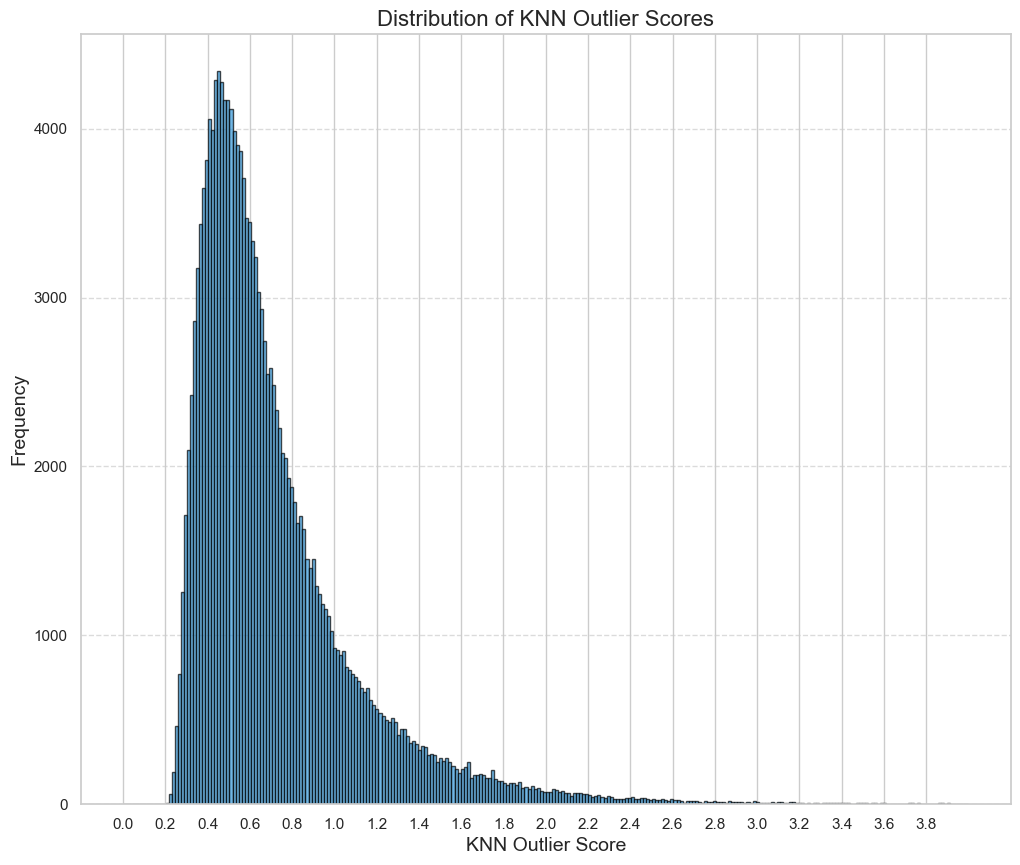

In [68]:
# Determining the threshold
plt.figure(figsize=(12, 10))  # Set the figure size

# Plotting the histogram
plt.hist(anomalies_knn, bins='auto', range=(0, 4), color='#3498db', edgecolor='black', alpha=0.7)

# Adding title and labels
plt.xticks(np.arange(0, 4, 0.2))
plt.title("Distribution of KNN Outlier Scores", fontsize=16)
plt.xlabel('KNN Outlier Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

### Step 3

I am choosing a threshold of 3.2

In [69]:
# Descriptive Statistics
threshold = 3.2 # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X,anomalies_knn, threshold)

,Group,Count,Count %,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,AvgTotalPayments DrgCodeZ-score,...,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,Anomaly_Score
0,Normal,162625,99.730169,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.01,...,-0.01,-0.00,-0.01,-0.01,-0.01,-0.0,-0.01,-0.01,-0.01,0.71
1,Outlier,440,0.269831,3.93,3.05,3.57,3.19,1.89,1.51,3.07,...,2.20,1.59,2.01,2.14,1.87,1.8,2.06,2.22,1.94,4.53


In [70]:
# Adding the anomaly scores to the original DataFrame
df['AnomalyScore_KNN'] = anomalies_knn

In [71]:
# Identify outliers based on KNN
outliers_knn = df[df['AnomalyScore_KNN'] > df['AnomalyScore_KNN'].quantile(0.99730169)]

# Display the outliers
print("\nOutliers based on KNN:")
outliers_knn = outliers_knn.sort_values(by = "AnomalyScore_KNN", ascending=False)
outliers_knn.head(10)


Outliers based on KNN:


,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN
112969,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,New York,NY,10021,3383,53113.58,19023.70,14880.39,...,-0.011819,2.469631,-0.213424,0.119541,0.006187,12.508544,-0.142778,0.204744,0.003105,38.088200
158518,220062,ADCARE HOSPITAL OF WORCESTER INC,107 LINCOLN STREET,Worcester,MA,1605,1571,4227.46,4967.56,4284.52,...,-0.829956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.033924
157581,50024,PARADISE VALLEY HOSPITAL,2400 EAST FOURTH STREET,National City,CA,91950,1696,33469.03,8192.84,7420.41,...,-0.413742,6.582915,-0.151781,-0.418267,-0.413742,6.582915,-0.151781,-0.418267,-0.413742,17.886722
109462,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,Crown Point,IN,46307,14,225729.14,131187.35,130466.57,...,8.795966,-0.587517,2.190349,2.230013,2.230822,-0.732558,7.775272,8.695223,8.795966,16.959651
39562,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,Stanford,CA,94305,11,929118.90,156158.18,154620.81,...,5.824430,-0.555901,6.243684,5.811877,5.824430,-0.555901,6.243684,5.811877,5.824430,15.250754
20388,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,Reading,PA,19605,143,24542.94,72797.93,7718.09,...,-0.199924,4.307256,-0.218595,5.725133,-0.162150,4.307256,-0.218595,5.725133,-0.162150,15.164862
111075,390256,MILTON S HERSHEY MEDICAL CENTER,500 UNIVERSITY DRIVE,Hershey,PA,17033,15,227821.80,100018.33,99114.86,...,6.386024,-0.710413,5.496024,5.879201,6.386024,-0.710413,5.496024,5.879201,6.386024,12.701857
47957,430095,AVERA HEART HOSPITAL OF SOUTH DAKOTA LLC,4500 W 69TH ST,Sioux Falls,SD,57108,121,43844.23,83484.14,9316.11,...,0.062729,2.351957,0.789150,3.882339,0.350992,2.351957,0.789150,3.882339,0.350992,12.614063
38923,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,Attleboro,MA,2703,11,7965.18,41482.09,1790.18,...,-0.863084,-0.768089,-0.743179,3.864210,-0.863084,-0.768089,-0.743179,3.864210,-0.863084,12.592150
37716,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,Baltimore,MD,21287,17,43980.52,41458.47,37236.00,...,2.206208,-0.736190,1.180813,1.177695,1.179098,-0.736190,1.180813,1.177695,1.179098,12.365259


## PCA

### Step 1

In [72]:
# Extracting features
X = df[features]

pca = PCA(contamination=0.05) 
pca.fit(X)

# get the prediction labels and outlier scores of the training data
anomaly_labels_pca = pca.labels_  # binary labels (0: inliers, 1: outliers)
anomaly_scores_pca = pca.decision_function(X) # You also can use .decision_function()

In [73]:
pca.get_params()

{'contamination': 0.05,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [74]:
print("The threshold for the defined comtanimation rate:" , pca.threshold_)

The threshold for the defined comtanimation rate: 1989361.8618493062


In [75]:
anomaly_scores_pca

array([ 839565.12705379,  612226.66287816,  569850.51925406, ...,
        758926.6865236 , 1080400.16931181,  888475.92997741])

### Step 2

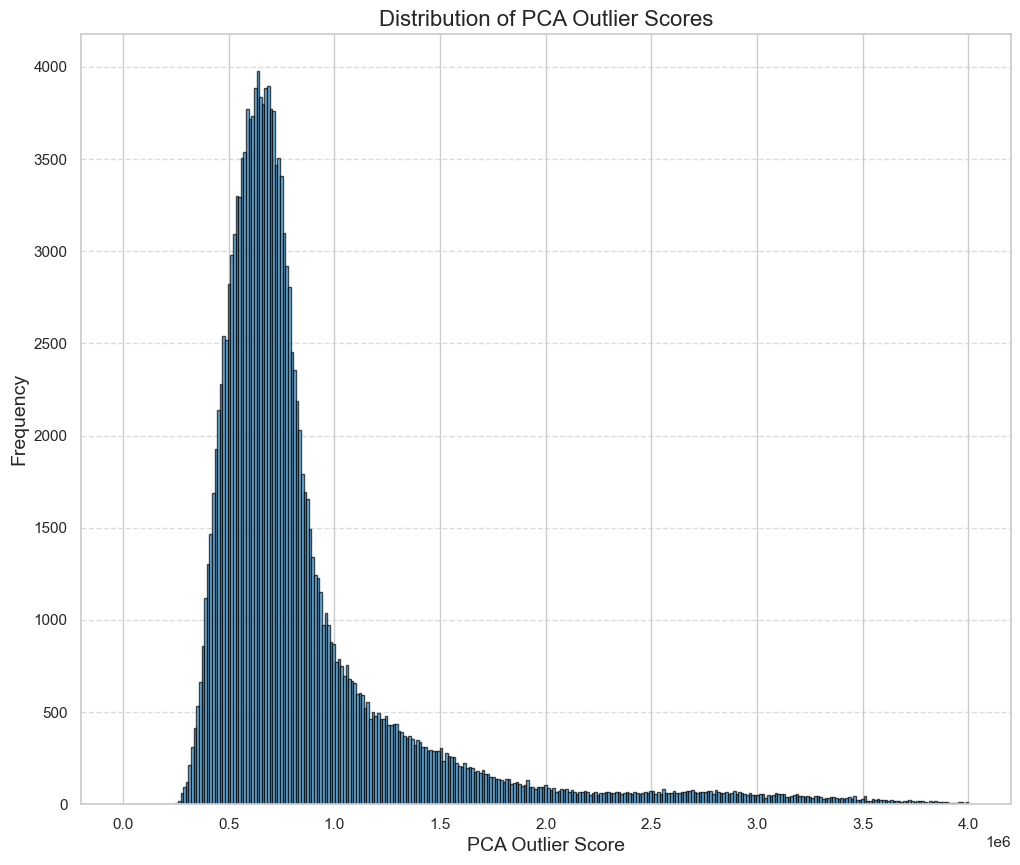

In [76]:
# Determining Threshold
# Determining the threshold
plt.figure(figsize=(12, 10))  # Set the figure size

# Plotting the histogram
plt.hist(anomaly_scores_pca, bins='auto', range=(0, 4000000), color='#3498db', edgecolor='black', alpha=0.7)

# Adding title and labels
plt.title("Distribution of PCA Outlier Scores", fontsize=16)
plt.xlabel('PCA Outlier Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [77]:
# Adding the anomaly scores to the original DataFrame
df['AnomalyScore_PCA'] = anomaly_scores_pca

### Step 3

I am choosing a threshold of 4000000

In [78]:
threshold = 4000000

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X,anomaly_scores_pca, threshold)

,Group,Count,Count %,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,AvgTotalPayments DrgCodeZ-score,...,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,Anomaly_Score
0,Normal,162610,99.72097,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,-0.01,...,-0.01,-0.00,-0.01,-0.01,-0.01,-0.00,-0.01,-0.01,-0.01,861719.14
1,Outlier,455,0.27903,3.74,4.79,4.97,4.85,1.15,1.19,1.91,...,3.89,1.39,3.40,3.43,3.36,1.55,3.49,3.52,3.45,4711493.92


In [79]:
# Identify outliers based on KNN
outliers_pca = df[df['AnomalyScore_PCA'] > df['AnomalyScore_PCA'].quantile(0.9972097)]

# Display the outliers
print("\nOutliers based on PCA:")
outliers_pca = outliers_pca.sort_values(by = "AnomalyScore_PCA", ascending=False)
outliers_pca.head()


Outliers based on PCA:


,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN,AnomalyScore_PCA
112969,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,New York,NY,10021,3383,53113.58,19023.70,14880.39,...,2.469631,-0.213424,0.119541,0.006187,12.508544,-0.142778,0.204744,0.003105,38.088200,1.543033e+07
157581,50024,PARADISE VALLEY HOSPITAL,2400 EAST FOURTH STREET,National City,CA,91950,1696,33469.03,8192.84,7420.41,...,6.582915,-0.151781,-0.418267,-0.413742,6.582915,-0.151781,-0.418267,-0.413742,17.886722,9.505821e+06
109462,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,Crown Point,IN,46307,14,225729.14,131187.35,130466.57,...,-0.587517,2.190349,2.230013,2.230822,-0.732558,7.775272,8.695223,8.795966,16.959651,9.282792e+06
39562,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,Stanford,CA,94305,11,929118.90,156158.18,154620.81,...,-0.555901,6.243684,5.811877,5.824430,-0.555901,6.243684,5.811877,5.824430,15.250754,8.746629e+06
158518,220062,ADCARE HOSPITAL OF WORCESTER INC,107 LINCOLN STREET,Worcester,MA,1605,1571,4227.46,4967.56,4284.52,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.033924,8.592095e+06


In [80]:
print("\nOutliers based on KNN:")
outliers_knn.head()


Outliers based on KNN:


,ProviderId,ProviderName,ProviderStreetAddress,ProviderCity,ProviderState,ProviderZipCode,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,...,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN
112969,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,New York,NY,10021,3383,53113.58,19023.70,14880.39,...,-0.011819,2.469631,-0.213424,0.119541,0.006187,12.508544,-0.142778,0.204744,0.003105,38.088200
158518,220062,ADCARE HOSPITAL OF WORCESTER INC,107 LINCOLN STREET,Worcester,MA,1605,1571,4227.46,4967.56,4284.52,...,-0.829956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.033924
157581,50024,PARADISE VALLEY HOSPITAL,2400 EAST FOURTH STREET,National City,CA,91950,1696,33469.03,8192.84,7420.41,...,-0.413742,6.582915,-0.151781,-0.418267,-0.413742,6.582915,-0.151781,-0.418267,-0.413742,17.886722
109462,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,Crown Point,IN,46307,14,225729.14,131187.35,130466.57,...,8.795966,-0.587517,2.190349,2.230013,2.230822,-0.732558,7.775272,8.695223,8.795966,16.959651
39562,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,Stanford,CA,94305,11,929118.90,156158.18,154620.81,...,5.824430,-0.555901,6.243684,5.811877,5.824430,-0.555901,6.243684,5.811877,5.824430,15.250754


The identification of providers as anomalous within the dataset can be attributed to several key factors, drawing insights from statistical measures such as Z-scores and anomaly scores derived from methods like K-nearest neighbors (KNN) and Principal Component Analysis (PCA). Let's analyze why these providers are considered anomalous:

In [81]:
# Remaining data with filtered outliers using KNN
df_no_outliers_knn = df[~df['ProviderId'].isin(outliers_knn['ProviderId'])]
df_no_outliers_knn.describe()

,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,...,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN,AnomalyScore_PCA
count,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,...,1.456170e+05,1.456170e+05,1.456170e+05,1.456170e+05,145617.000000,145617.000000,145617.000000,145617.000000,145617.000000,1.456170e+05
mean,41.260389,34335.650185,9343.852150,8156.321361,-0.030265,-0.044384,-0.042766,-0.041212,-0.048874,-0.078999,...,-9.368700e-18,-6.245800e-18,1.249160e-17,3.122900e-18,-0.000900,-0.001955,-0.000862,-0.000692,0.686487,8.435449e+05
std,45.003012,31761.180268,7108.173343,6792.175354,0.881087,0.928697,0.936351,0.939536,0.895877,0.890467,...,9.894788e-01,9.894892e-01,9.894892e-01,9.894892e-01,0.987147,0.988637,0.989294,0.989553,0.364103,5.268455e+05
min,11.000000,2459.400000,2673.000000,1148.900000,-0.640744,-1.049923,-0.937124,-1.018731,-1.139574,-1.943315,...,-1.886238e+00,-2.346608e+00,-1.911163e+00,-1.813800e+00,-1.886238,-2.346608,-1.911163,-1.813800,0.200289,2.487787e+05
25%,17.000000,15547.200000,5131.000000,4090.710000,-0.515764,-0.603401,-0.601991,-0.607617,-0.676782,-0.692420,...,-6.183559e-01,-6.294947e-01,-6.323712e-01,-6.411959e-01,-0.614675,-0.628764,-0.631871,-0.640770,0.444606,5.682079e+05
50%,26.000000,24301.530000,7012.120000,5967.450000,-0.321708,-0.338293,-0.350383,-0.344321,-0.316432,-0.306431,...,-3.294834e-01,-3.426135e-01,-3.319433e-01,-3.283783e-01,-0.329080,-0.342909,-0.332377,-0.328872,0.584499,6.964571e+05
75%,48.000000,41292.000000,10922.310000,9740.780000,0.099953,0.165777,0.172706,0.186775,0.287620,0.287551,...,2.786257e-01,2.828635e-01,2.916912e-01,3.065493e-01,0.269597,0.278295,0.289190,0.304098,0.809974,8.791037e+05
max,1032.000000,508863.740000,87248.900000,84700.870000,19.014010,12.083283,9.578509,9.053476,10.363079,8.764894,...,8.883120e+00,6.680248e+00,6.193001e+00,6.431412e+00,9.961438,6.717779,6.650866,6.705898,3.198820,5.585777e+06


In [82]:
outliers_knn.describe()

,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,...,AvgMedicarePayments ProviderCityZ-score,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,...,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,239.404545,150787.052955,38156.033841,32959.637227,3.925180,3.053862,3.566464,3.188491,1.890432,1.505122,...,2.197259,1.589859,2.010413,2.138137,1.869970,1.803585,2.056145,2.223892,1.942801,4.534782
std,356.144035,151253.272951,27531.775481,26728.948999,7.020644,3.854788,3.445201,3.474328,3.398348,2.331055,...,2.350558,2.742922,2.045919,2.052593,1.963556,3.066459,2.099567,2.111987,2.036376,2.576435
min,11.000000,4227.460000,3913.140000,1790.180000,-0.640744,-0.977703,-0.759831,-0.926298,-1.076990,-1.498547,...,-1.421974,-1.125108,-1.758830,-1.417191,-1.421974,-1.101689,-1.758830,-1.417191,-1.421974,3.201039
25%,18.000000,42208.792500,16077.190000,11654.147500,-0.477669,0.220112,0.827495,0.447104,-0.607444,-0.242234,...,0.236813,-0.562240,0.254348,0.358289,0.234758,-0.558378,0.217066,0.401579,0.264937,3.476186
50%,60.500000,99288.555000,28287.260000,23226.885000,0.371019,1.616803,2.457329,1.978623,0.442919,0.791781,...,1.516406,0.270665,1.594553,1.799282,1.390252,0.349946,1.694009,1.829216,1.434186,3.853381
75%,359.250000,199503.190000,55597.310000,48402.752500,6.061063,4.370276,6.059616,5.280759,3.298904,2.746395,...,3.950956,3.014008,3.769077,3.865258,3.587648,3.584308,3.767199,3.942017,3.749194,4.634082
max,3383.000000,929118.900000,156158.180000,154620.810000,60.298806,17.778039,17.435504,18.624622,23.031720,13.258797,...,10.039672,9.106176,6.626803,7.213319,7.037680,12.508544,7.775272,8.695223,8.795966,38.088200


I chose a threshold so that the count of outliers to be less than 500.

### Cluster Analysis:

**Size of the Cluster:** The count of providers in the outlier cluster is relatively small (440 providers). This indicates that the cluster is not a large portion of the dataset.
Average Statistics:

### Average Statistics:

**Total Discharges:** The average total discharges for providers in the outlier cluster are substantially higher than the overall average (239.4 vs. 41.26). This suggests that providers in this cluster handle a much larger volume of discharges.

**Average Covered Charges:** The average covered charges for providers in the outlier cluster are significantly higher than the overall average (150,787 vs. 34,335.65). This indicates that these providers charge more for their services.

**Average Total Payments and Medicare Payments:** Similarly, both average total payments and average Medicare payments for providers in the outlier cluster are much higher than the overall averages. This may suggest higher costs or more complex cases being handled by these providers.

**Z-scores:**

**Interstate Region Z-scores:** The z-scores for interstate region-related features are notably higher in the outlier cluster. This could indicate that these providers operate in regions where the healthcare landscape is different or more demanding.

**DrgCode Z-scores:** The z-scores for DRG code-related features are also elevated in the outlier cluster. This may suggest that these providers deal with specific types of medical cases that deviate from the norm.

**ProviderId and ZipCode Z-scores:** Elevated z-scores for provider ID and zip code-related features in the outlier cluster might imply that these providers or their locations have unique characteristics compared to others.

### Anomaly Scores (KNN):

**Higher Anomaly Scores:** Providers in the outlier cluster have higher anomaly scores, indicating that they deviate significantly from the majority of providers in the dataset.

### Business Insight:

**Potential High-Cost Providers:** Providers in the outlier cluster may be potential high-cost outliers due to their significantly higher average covered charges, total payments, and Medicare payments. Investigating these providers could reveal insights into the reasons for their higher costs, such as specialized services, advanced technologies, or unique patient populations.

**Regional and Specialization Focus:** The elevated z-scores for region, DRG code, provider ID, and zip code suggest that providers in the outlier cluster may have a specific regional or specialization focus that differentiates them from the rest.

**Risk Management:** Understanding the characteristics of providers in the outlier cluster can be valuable for risk management and targeted investigations. It allows healthcare organizations and regulatory bodies to focus their resources on areas where anomalies are more likely to occur.

In summary, the identified cluster of providers exhibits characteristics that deviate significantly from the norm, indicating potential outliers with higher costs and unique regional or specialization focuses. Further investigation into these providers can provide valuable insights for risk management, cost control, and quality improvement in the healthcare system.

In [83]:
# Remaining data with filtered outliers using PCA
df_no_outliers_pca = df[~df['ProviderId'].isin(outliers_pca['ProviderId'])]
df_no_outliers_pca.describe()

,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,...,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN,AnomalyScore_PCA
count,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,...,1.368240e+05,1.368240e+05,1.368240e+05,1.368240e+05,136824.000000,136824.000000,136824.000000,136824.000000,136824.000000,1.368240e+05
mean,40.667164,33706.526926,9295.592830,8108.678156,-0.043527,-0.063967,-0.052033,-0.051065,-0.072234,-0.098957,...,-4.985390e-18,6.647187e-18,-6.647187e-18,-1.329437e-17,-0.000522,-0.002502,-0.001433,-0.001408,0.689347,8.450310e+05
std,43.970618,30781.401339,6991.102333,6672.400105,0.856671,0.899086,0.915513,0.916707,0.893494,0.880013,...,9.890316e-01,9.890427e-01,9.890427e-01,9.890427e-01,0.988269,0.986932,0.987433,0.987337,0.377640,5.174966e+05
min,11.000000,2459.400000,2673.000000,1148.900000,-0.640744,-1.049923,-0.937124,-1.018731,-1.139574,-1.943315,...,-1.886238e+00,-2.346608e+00,-1.911163e+00,-1.813800e+00,-1.886238,-2.346608,-1.911163,-1.813800,0.200289,2.487787e+05
25%,16.000000,15379.510000,5120.547500,4079.507500,-0.515764,-0.608362,-0.603258,-0.609141,-0.688169,-0.703598,...,-6.233142e-01,-6.335356e-01,-6.361496e-01,-6.459075e-01,-0.619639,-0.632767,-0.635624,-0.645076,0.444082,5.688685e+05
50%,26.000000,23941.470000,6996.075000,5952.335000,-0.323352,-0.348387,-0.353389,-0.347450,-0.343893,-0.318663,...,-3.329780e-01,-3.429494e-01,-3.322525e-01,-3.287938e-01,-0.332803,-0.343642,-0.333372,-0.329890,0.584431,6.977697e+05
75%,47.000000,40617.687500,10886.827500,9712.685000,0.080712,0.144510,0.164791,0.178670,0.255020,0.260659,...,2.835632e-01,2.878928e-01,2.967959e-01,3.125140e-01,0.274175,0.282243,0.292966,0.309043,0.811670,8.831946e+05
max,732.000000,482847.500000,78710.080000,76608.530000,13.241663,10.373664,8.205447,8.110839,11.719181,8.762384,...,8.209330e+00,6.368413e+00,6.125621e+00,6.094030e+00,8.962212,6.202162,6.167526,6.195316,6.381697,3.999058e+06


In [84]:
outliers_pca.describe()

,TotalDischarges,AvgCoveredCharges,AvgTotalPayments,AvgMedicarePayments,TotalDischarges InterstateRegionZ-score,AvgCoveredCharges InterstateRegionZ-score,AvgTotalPayments InterstateRegionZ-score,AvgMedicarePayments InterstateRegionZ-score,TotalDischarges DrgCodeZ-score,AvgCoveredCharges DrgCodeZ-score,...,TotalDischarges ProviderIdZ-score,AvgCoveredCharges ProviderIdZ-score,AvgTotalPayments ProviderIdZ-score,AvgMedicarePayments ProviderIdZ-score,TotalDischarges ZipCodeZ-score,AvgCoveredCharges ZipCodeZ-score,AvgTotalPayments ZipCodeZ-score,AvgMedicarePayments ZipCodeZ-score,AnomalyScore_KNN,AnomalyScore_PCA
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,4.550000e+02
mean,229.153846,205439.212198,48208.564176,44291.329407,3.735243,4.789394,4.974496,4.852466,1.152832,1.192873,...,1.385523,3.400942,3.430909,3.356691,1.550121,3.485379,3.520439,3.448150,3.685485,4.711494e+06
std,385.313189,159263.970482,26683.073772,25977.435198,7.611168,4.075444,3.342065,3.394749,2.902353,1.872615,...,3.344313,2.166499,2.057069,2.091877,3.634894,2.241870,2.130573,2.170883,2.809053,9.298109e+05
min,11.000000,4227.460000,4624.850000,1790.180000,-0.640744,-0.889815,-0.708166,-0.926298,-0.998773,-1.446357,...,-1.059677,-1.175628,-0.697230,-0.863084,-1.044961,-1.007824,-0.697230,-0.863084,1.318197,4.000693e+06
25%,15.000000,64480.925000,21741.010000,16394.715000,-0.535005,0.954098,1.358344,0.969642,-0.642137,-0.073873,...,-0.671931,0.877665,0.824926,0.595766,-0.683053,0.857103,0.782340,0.558245,2.358847,4.172213e+06
50%,24.000000,177728.220000,51286.360000,47195.060000,-0.361834,4.715547,5.447476,5.317614,-0.082062,0.697028,...,-0.477819,4.241829,4.133316,4.170436,-0.449648,4.314901,4.258675,4.267364,2.924255,4.472964e+06
75%,487.000000,300532.755000,65862.440000,60769.255000,9.759014,7.525140,7.308991,7.194921,2.424213,2.165320,...,2.560365,5.017242,4.923130,4.787638,2.886822,5.125795,5.041597,4.993764,3.958979,4.921926e+06
max,3383.000000,929118.900000,156158.180000,154620.810000,60.298806,17.778039,17.435504,18.624622,23.031720,13.258797,...,9.106176,6.680248,7.213319,7.037680,12.508544,7.775272,8.695223,8.795966,38.088200,1.543033e+07


I chose a threshold so that the count of outliers to be less than 500.

### Cluster Analysis:

**Size of the Cluster:** The count of providers in the outlier cluster is relatively small (455 providers). Similar to the previous analysis, this indicates that the cluster is not a large portion of the dataset.

### Average Statistics:

**Total Discharges:** The average total discharges for providers in the outlier cluster are higher than the overall average (229.15 vs. 40.67). This suggests that providers in this cluster handle a larger volume of discharges.

**Average Covered Charges:** The average covered charges for providers in the outlier cluster are significantly higher than the overall average (205,439.21 vs. 33,706.53). This indicates that these providers charge more for their services.

**Average Total Payments and Medicare Payments:** Both average total payments and average Medicare payments for providers in the outlier cluster are much higher than the overall averages. This may suggest higher costs or more complex cases being handled by these providers.

### Z-scores:

**Interstate Region Z-scores:** The z-scores for interstate region-related features are notably higher in the outlier cluster, indicating that these providers operate in regions with different characteristics.

**DrgCode Z-scores:** The z-scores for DRG code-related features are elevated in the outlier cluster, suggesting that these providers deal with specific types of medical cases that deviate from the norm.

**ProviderId and ZipCode Z-scores:** Elevated z-scores for provider ID and zip code-related features in the outlier cluster might imply that these providers or their locations have unique characteristics compared to others.

### Anomaly Scores (PCA):

**Higher Anomaly Scores:** Providers in the outlier cluster have higher anomaly scores, indicating that they deviate significantly from the majority of providers in the dataset.
Business Insight:

### Business Insight:

**Potential High-Cost Providers:** Providers in the outlier cluster may be potential high-cost outliers due to their significantly higher average covered charges, total payments, and Medicare payments. Investigating these providers could reveal insights into the reasons for their higher costs, such as specialized services, advanced technologies, or unique patient populations.

**Regional and Specialization Focus:** The elevated z-scores for region, DRG code, provider ID, and zip code suggest that providers in the outlier cluster may have a specific regional or specialization focus that differentiates them from the rest.

**Risk Management:** Understanding the characteristics of providers in the outlier cluster can be valuable for risk management and targeted investigations. It allows healthcare organizations and regulatory bodies to focus their resources on areas where anomalies are more likely to occur.

In summary, the second set of data identifies a cluster of providers with characteristics that deviate significantly from the norm, indicating potential outliers with higher costs and unique regional or specialization focuses. Further investigation into these providers can provide valuable insights for risk management, cost control, and quality improvement in the healthcare system.